## Import modules

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from streetview.streetview import search, api, download
from streetview.streetview import tools
import geopandas as gpd
import json
import os
import math
import requests
import geometry

## Set input and output folders

In [3]:
input_folder='data'
out_folder='output\panos'

## Set Google API key
Create a config.json file containing below to save your API key:  
{  
    "api_key": your_API_Key  
}  

In [4]:
with open('config.json', 'r') as f:
    config = json.load(f)
GOOGLE_MAPS_API_KEY = config['api_key']

## Load GNAF points
We use the points data at Wagga Wagga for demonstration:

In [5]:
add_points=os.path.join(input_folder,"Final_Wagga.shp")
gdf_points=gpd.read_file(add_points).to_crs('epsg:4326')
gdf_points.head()

,WALL_M,STEPS,USAGE,STOREYS,ASSESSOR,address,Area_1,PMF,Dep_500,Dep_200,Dep_100,Dep_50,Dep_20,Dep_10,Ground_Lev,Floor_Leve,AGE,UFI,ZONE_DESCR,geometry
0,Metal,1,Commercial,1,ROBERT,3 MOORONG STREET,721.960449,3.6338,-9999.0000,-9999.0,-9999.0,-9999.0,-9999.0,-9999.0,178.856,179.136,> 1960,2128,Light Industrial,POINT (147.34855 -35.1025)
1,Metal,1,Commercial,1,ROBERT,3 MOORONG STREET,314.036351,3.4780,-9999.0000,-9999.0,-9999.0,-9999.0,-9999.0,-9999.0,178.856,179.136,> 1960,2129,Light Industrial,POINT (147.34797 -35.10244)
2,Metal,1,Commercial,1,ROBERT,UNIT 1 29 MOORONG STREET,1783.805231,3.2973,0.9431,-9999.0,-9999.0,-9999.0,-9999.0,-9999.0,179.137,179.417,> 1960,2130,Light Industrial,POINT (147.34698 -35.10443)
3,Metal,1,Commercial,1,ROBERT,UNIT 1 29 MOORONG STREET,346.207850,4.6240,-9999.0000,-9999.0,-9999.0,-9999.0,-9999.0,-9999.0,178.455,178.735,> 1960,2141,Light Industrial,POINT (147.34792 -35.10482)
4,Metal,1,Commercial,1,ROBERT,11 MOORONG STREET,615.235606,3.4026,-9999.0000,-9999.0,-9999.0,-9999.0,-9999.0,-9999.0,178.997,179.277,> 1960,2156,Light Industrial,POINT (147.34845 -35.10319)


### View points

In [6]:
gdf_points.explore(attr='USAGE')

### Filter by usage - keeping only residential

In [7]:
gdf_points=gdf_points[gdf_points['USAGE'] == 'Residential']
gdf_points

,WALL_M,STEPS,USAGE,STOREYS,ASSESSOR,address,Area_1,PMF,Dep_500,Dep_200,Dep_100,Dep_50,Dep_20,Dep_10,Ground_Lev,Floor_Leve,AGE,UFI,ZONE_DESCR,geometry
5,Fibro,1,Residential,1,ROBERT,5 MOORONG STREET,166.409383,4.3459,-9999.0000,-9999.0000,-9999.0,-9999.0,-9999.0,-9999.0,178.900,179.180,> 1960,2157,Light Industrial,POINT (147.3487 -35.10277)
6,Timber,2,Residential,1,ROBERT,23 MOORONG STREET,129.996253,5.4025,1.1994,0.5024,-9999.0,-9999.0,-9999.0,-9999.0,178.544,178.824,> 1960,2158,Light Industrial,POINT (147.34846 -35.10416)
8,Brick,1,Residential,1,ROBERT,26 INCARNIE CRESCENT,112.896592,6.4436,1.6234,-9999.0000,-9999.0,-9999.0,-9999.0,-9999.0,178.752,179.032,> 1960,2177,General Residential,POINT (147.36399 -35.09983)
9,Brick,1,Residential,1,ROBERT,46 INCARNIE CRESCENT,119.302365,6.4954,1.6607,-9999.0000,-9999.0,-9999.0,-9999.0,-9999.0,178.641,178.921,> 1960,2178,General Residential,POINT (147.3652 -35.09901)
10,Brick,1,Residential,1,ROBERT,44 INCARNIE CRESCENT,122.266267,6.5136,1.6849,0.7914,-9999.0,-9999.0,-9999.0,-9999.0,178.500,178.780,> 1960,2179,General Residential,POINT (147.36497 -35.09897)
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3395,Brick,2,Residential,1,Carly,24 FITZHARDINGE STREET,213.502191,2.3644,-9999.0000,-9999.0000,-9999.0,-9999.0,-9999.0,-9999.0,181.673,181.953,< 1960,3120,Commercial Core,POINT (147.37011 -35.11781)
3422,Brick,2,Residential,1,Carly,62 TOMPSON STREET,366.246936,3.0249,0.2280,-9999.0000,-9999.0,-9999.0,-9999.0,-9999.0,180.568,180.848,< 1960,3275,Commercial Core,POINT (147.36919 -35.11215)
3425,Other,5,Residential,1,Carly,20 FORSYTH STREET,233.949841,5.8913,1.9842,0.4650,-9999.0,-9999.0,-9999.0,-9999.0,180.012,180.292,< 1960,3314,Commercial Core,POINT (147.37388 -35.11484)
3433,Brick,4,Residential,1,Carly,22 FITZHARDINGE STREET,251.725817,2.6621,-9999.0000,-9999.0000,-9999.0,-9999.0,-9999.0,-9999.0,181.651,181.931,< 1960,3345,Commercial Core,POINT (147.37013 -35.1179)


Test workflow with first point:

In [8]:
i=0
lon=gdf_points.geometry.iloc[i].x
lat=gdf_points.geometry.iloc[i].y

## Get ID of closest panorama using Google API

In [9]:
# Base URL for the Street View Metadata API (for metadata)
metadata_url = f"https://maps.googleapis.com/maps/api/streetview/metadata?location={lat},{lon}&key={GOOGLE_MAPS_API_KEY}"

# Fetch the metadata
metadata_response = requests.get(metadata_url)
metadata = metadata_response.json()

# Check if metadata request is successful and contains panorama data
if metadata.get('status') == 'OK':  
    # Print metadata details
    print("Panorama Metadata:")
    for key, value in metadata.items():
        print(f"{key}: {value}")
else:
    print(f"Error fetching metadata. Status: {metadata.get('status')}")


Panorama Metadata:
copyright: © Google
date: 2019-09
location: {'lat': -35.10275169047986, 'lng': 147.3490123204816}
pano_id: cRj7D5icRyy66mCT2OlseA
status: OK


## Search panorama images by coordinates
The photos on Google street view are panoramas. Each parnorama has its own unique ID. Retrieving photos is a two step process. First, you must translate GPS coordinates into panorama IDs. The following code retrieves a list of the closest panoramas:

In [10]:
panos = search.search_panoramas(lat=lat, lon=lon)
panos

[Panorama(pano_id='mdYVMXdGLaeb6Wtx5eJYAg', lat=-35.10272222058492, lon=147.3490081817781, heading=7.583515167236328, pitch=89.07627868652344, roll=358.0917358398438, date='2007-11', elevation=None),
 Panorama(pano_id='G5JcC6Wkw8tSy1232ee4Fw', lat=-35.10275610119986, lon=147.3490550870935, heading=188.8988800048828, pitch=89.41365814208984, roll=0.4390824437141418, date='2015-05', elevation=None),
 Panorama(pano_id='wI0FplRNLglaHv33_YL2rA', lat=-35.10312353961378, lon=147.3489309260112, heading=8.671233177185059, pitch=89.92214965820312, roll=357.8056030273438, date=None, elevation=None),
 Panorama(pano_id='r_-mKGJi0uYNrJ1fyi7e0Q', lat=-35.10303855487741, lon=147.3489470496988, heading=8.848934173583984, pitch=89.97593688964844, roll=357.8277282714844, date=None, elevation=None),
 Panorama(pano_id='dYTwrsWe56ZUOAYbiOd6FQ', lat=-35.10295484603914, lon=147.348963173389, heading=8.860435485839844, pitch=89.7867660522461, roll=358.5726318359375, date=None, elevation=None),
 Panorama(pano_i

Sort panoramas by distance to the building point and keep only top three panoramas:

In [11]:
# panos_filtered={'dists':[],'panos':[]}
# for pano in panos:
#     dist=math.sqrt((lat-pano.lat)**2+(lon-pano.lon)**2)
#     panos_filtered['panos'].append(pano)
#     panos_filtered['dists'].append(dist)
# sorted_data = sorted(zip(panos_filtered['dists'], panos_filtered['panos']), key=lambda x: x[0])
# dists_sorted, panos_sorted = zip(*sorted_data[:3])
# panos_filtered['dists'] = list(dists_sorted)
# panos_filtered['panos'] = list(panos_sorted)
# panos_filtered

## Find pano matching the API in streetview search results to get metadata including:
- latitude and longitude
- heading/bearing angle
- pitch and roll angles (how are they retrieved?)

In [12]:
for pano in panos:
    if pano.pano_id==metadata.get('pano_id'):
        heading=pano.heading
        pano_id=metadata.get('pano_id')
        print('Found matching pano with id of ',pano_id)
        print('heading angle of ',heading)

Found matching pano with id of  cRj7D5icRyy66mCT2OlseA
heading angle of  9.459732055664062


## Download pano images
The code below uses the panorama ids to download streetview images and the panorama in an asynchronous context. Street View Static API images can be returned in any size up to 640 x 640 pixels.

In [13]:
zoom_level=3 # pano dimension (excluding user-uploaded data): 2^zoom*512, 2^(zoom-1)*512
# meta = api.get_panorama_meta(pano_id=pano_id, api_key=GOOGLE_MAPS_API_KEY)
gsv_pano = await download.get_panorama_async(pano_id=pano_id,
                                             zoom=zoom_level)
# Crop the black border at the bottom and right of the panorama
gsv_pano = tools.crop_bottom_and_right_black_border(gsv_pano)
gsv_pano.save(os.path.join(out_folder,"pano_"+pano_id+".jpg"), "jpeg")

## Localise building of interest

House location (horizontal pixel range) within pano image:

In [14]:
# below are standard google pano image dimension which does not apply to user uploaded data
# width=512*(2**zoom_level) # pano image width
# height=512*(2**(zoom_level-1)) # pano image height
location = geometry.localize_house_in_panorama(metadata['location']['lat'], 
                           metadata['location']['lng'], 
                           lat, lon, heading, gsv_pano.width)
location

{'camera_house_bearing': -93.7300400271735,
 'camera_house_bearing_range': (-123.7300400271735, -63.7300400271735),
 'horizontal_pixel_house': 873.9297043019371,
 'horizontal_pixel_range_house': (532.5963709686037, 1215.2630376352704)}

## Download street view images (optional)

In [15]:
# heading_street_view=location['camera_house_bearing']
# if heading_street_view<0:
#     heading_street_view=heading_street_view+360
    
# gsv_image = api.get_streetview(pano_id=pano_id,
#                                heading=heading_street_view,
#                                pitch=0,
#                                api_key=GOOGLE_MAPS_API_KEY)
# gsv_image.save(os.path.join(out_folder,"street_view_"+pano_id+".jpg"), "jpeg")

## Clip panorama image to localised area
- Horizontally clipped to calculated pixel range
- Vertically clipped based on hard-coded upper and lower crop proportions range

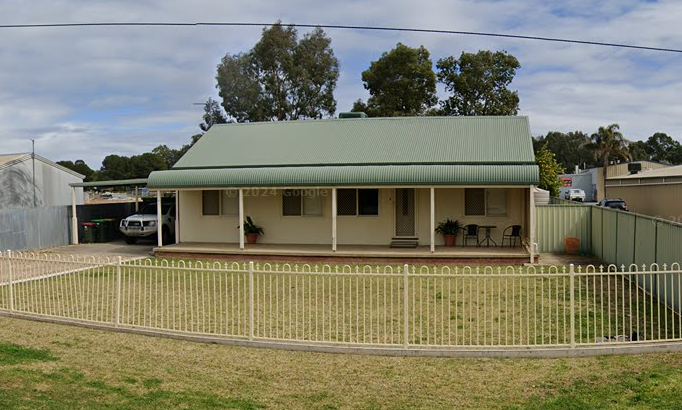

In [16]:
upper_crop=0.4
lower_crop=0.6
gsv_pano_clipped=gsv_pano.crop(box=(location['horizontal_pixel_range_house'][0],
                   upper_crop*gsv_pano.height,
                   location['horizontal_pixel_range_house'][1],
                   lower_crop*gsv_pano.height
                   ))
gsv_pano_clipped

### Save image

In [17]:
gsv_pano_clipped.save(os.path.join(out_folder,"pano_clipped_"+pano_id+".jpg"), "jpeg")

## Batch processing

In [18]:
n_sample=20
upper_crop=0.25
lower_crop=0.6
for i in range(21,40):
    lon=gdf_points.geometry.iloc[i].x
    lat=gdf_points.geometry.iloc[i].y

    # Base URL for the Street View Metadata API (for metadata)
    metadata_url = f"https://maps.googleapis.com/maps/api/streetview/metadata?location={lat},{lon}&key={GOOGLE_MAPS_API_KEY}"

    try:
        # Fetch the metadata
        metadata_response = requests.get(metadata_url)
        metadata = metadata_response.json()

        # Check if metadata request is successful and contains panorama data
        if metadata.get('status') == 'OK':  
            # Print metadata details
            print("Panorama Metadata:")
            for key, value in metadata.items():
                print(f"{key}: {value}")
        else:
            print(f"Error fetching metadata. Status: {metadata.get('status')}")

        panos = search.search_panoramas(lat=lat, lon=lon)

        for pano in panos:
            if pano.pano_id==metadata.get('pano_id'):
                heading=pano.heading
                pano_id=metadata.get('pano_id')
                print('Found matching pano with id of ',pano_id)
                print('heading angle of ',heading)
        if not os.path.exists(os.path.join(out_folder,"pano_"+pano_id+".jpg")): # avoid redownloading existing pano
            # meta = api.get_panorama_meta(pano_id=pano_id, api_key=GOOGLE_MAPS_API_KEY)
            gsv_pano = await download.get_panorama_async(pano_id=pano_id,
                                                        zoom=zoom_level)
            # Crop the black border at the bottom and right of the panorama
            gsv_pano = tools.crop_bottom_and_right_black_border(gsv_pano)
            gsv_pano.save(os.path.join(out_folder,"pano_"+pano_id+".jpg"), "jpeg")

            location = geometry.localize_house_in_panorama(metadata['location']['lat'], 
                                    metadata['location']['lng'], 
                                    lat, lon, heading, gsv_pano.width)
            print(location)

            gsv_pano_clipped=gsv_pano.crop(box=(location['horizontal_pixel_range_house'][0],
                            upper_crop*gsv_pano.height,
                            location['horizontal_pixel_range_house'][1],
                            lower_crop*gsv_pano.height
                            ))
            gsv_pano_clipped.save(os.path.join(out_folder,"pano_clipped_"+pano_id+".jpg"), "jpeg")
    except Exception as e:  # Catch any other unexpected errors:
        print(f"An error occurred: {e}, skipping...")

Panorama Metadata:
copyright: © Google
date: 2015-05
location: {'lat': -35.09964486207519, 'lng': 147.363711718103}
pano_id: tckRrdJAwxlA7XhvMkgzeA
status: OK
Found matching pano with id of  tckRrdJAwxlA7XhvMkgzeA
heading angle of  7.012480735778809
Found black border. Cropping from 4096x2048 to 3584x1664
{'camera_house_bearing': 82.79983727870113, 'camera_house_bearing_range': (52.79983727870113, 112.79983727870113), 'horizontal_pixel_house': 1037.49476152824, 'horizontal_pixel_range_house': (1336.1614281949066, 738.8280948615732)}
An error occurred: Coordinate 'right' is less than 'left', skipping...
Panorama Metadata:
copyright: © Google
date: 2015-05
location: {'lat': -35.09753613720559, 'lng': 147.3619019996883}
pano_id: 8YSuFHs7shOF9YMBCDpS8A
status: OK
Found matching pano with id of  8YSuFHs7shOF9YMBCDpS8A
heading angle of  198.3856658935547
Found black border. Cropping from 4096x2048 to 3584x1664
{'camera_house_bearing': -69.33186945791392, 'camera_house_bearing_range': (-99.33